In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st

In [2]:
# Constants
S0 = 10  # Initial risky asset price
B0 = 1 #Starting bank account "price"
T = 1  # Total time to expiration (in years)
r = 0.02  # Risk-free interest rate
sigma = 0.2  # Volatility
N = 5000 # Number of time steps
K = 10  # Strike price
mu = 0.05 # drift
dt = T/N # time step

In [3]:
# Function to calculate the up and down factors for the risky asset
def calculate_risky_up_down_factors(r, sigma, dt):
    u = np.exp(r * dt + sigma * np.sqrt(dt))
    d = np.exp(r * dt - sigma * np.sqrt(dt))
    return u, d

# Function to calculate the up and down factors for the bank account
def calculate_bank_account_up_down_factors(r, sigma, dt):
    u = np.exp(r * dt)
    d = np.exp(r * dt)
    return u, d

# Function to compute q, as derived in Q1
def get_q(sigma, dt):
    return (1-np.exp(-sigma*np.sqrt(dt)))/(np.exp(sigma*np.sqrt(dt))-np.exp(-sigma*np.sqrt(dt)))

def get_q_s(sigma, dt):
    return (1-np.exp(sigma*np.sqrt(dt)))/(np.exp(-sigma*np.sqrt(dt))-np.exp(sigma*np.sqrt(dt)))

In [4]:
# Produce the trees for the risky asset
def generate_risky_tree(N, r, sigma, dt):
    risky_asset_prices = np.zeros((N + 1, N + 1))
    u, d = calculate_risky_up_down_factors(r, sigma, dt)
    for i in range(N+1):
        for j in range(i + 1):
            risky_asset_prices[j, i] = S0 * (u ** (i-j)) * (d ** j)
            
    return risky_asset_prices

# Produce the trees for the bank account
def generate_BA_tree(N, r, sigma, dt):
    bank_account_prices = np.zeros((N + 1, N + 1))
    u, d = calculate_bank_account_up_down_factors(r, sigma, dt)
    for i in range(N+1):
        for j in range(i + 1):
            bank_account_prices[j, i] = B0 * (u ** (i-j)) * (d ** j)
            
    return bank_account_prices

In [9]:
# Now, time to value American put option, using the bank account as the numeraire
# Also, draw the exercise boundary
# Start with the payouts

# Helper Function
# Find the price at each time step where we should exercise
def first_one(arr, axis):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), -1)

K = 10 # strike price
def generate_option_tree_Bnum(N, dt, K, r, sigma):
    q = get_q(sigma, dt)
    ex_boundary = np.zeros((N + 1, N + 1))
    put_opt_prices = np.zeros((N + 1, N + 1))
    for i in range(N+1):
        put_opt_prices[i,-1] = max(0, K - risky_tree[i, -1])
        ex_boundary[i,-1] = 1 if (K - risky_tree[i, -1] >= 0) else 0
    
    # Now, go back inductively
    for i in range(N-1, -1, -1):
        for j in range(0, i+1):
            hold_value = np.exp(-r*dt) * (q * put_opt_prices[j, i+1] + (1-q) * put_opt_prices[j+1, i+1])
            exercise_value = max(0, K - risky_tree[j, i])
            put_opt_prices[j, i] = max(exercise_value, hold_value)
            ex_boundary[j, i] = 1 if (exercise_value > hold_value) else 0
    
    option_price = put_opt_prices[0,0]

    # Plot the Exercise Boundary
    ex_index = first_one(ex_boundary, 0).astype(int)
    ex_prices = np.zeros(N+1)
    t= np.linspace(0,T,N+1)
    
    for i in range(N+1):
        if ex_index[i] == -1:
            ex_prices[i] = np.nan
        else:
            ex_prices[i] = risky_tree[ex_index[i], i]
    
    # Plot the exercise boundary
    plt.plot(t, ex_prices, label="Exercise Boundary", color='r')
    plt.plot(t, [K] * (N + 1), label="Strike Price", color='k',linestyle = '--',
             linewidth =3)
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Asset S Price ($)", fontsize=15)
    plt.legend(fontsize=12, loc = "center left")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    plt.title("American Put Option Exercise Boundary (B Numeraire)")
    
    plt.show()
    
    return put_opt_prices, option_price, ex_prices

In [ ]:
# Generate Results
risky_tree = generate_risky_tree(N, r, sigma, dt)
BA_tree = generate_BA_tree(N, r, sigma, dt)
put_opt_tree, price, ex_prices = generate_option_tree_Bnum(N, dt, K, r, sigma)
print("Option Price: " , price)

In [10]:
#Now do the same with S as the numeraire. Must use q_s now.

def generate_option_tree_Snum(N, dt, K, r, sigma):
    q_s = get_q_s(sigma, dt)
    ex_boundary_S = np.zeros((N + 1, N + 1))
    put_opt_prices = np.zeros((N + 1, N + 1))
    for i in range(N+1):
        put_opt_prices[i,-1] = max(0, K - risky_tree[i, -1])
        ex_boundary_S[i,-1] = 1 if (K - risky_tree[i, -1] >= 0) else 0
    
    # Now, go back inductively
    for i in range(N-1, -1, -1):
        for j in range(0, i+1):
            hold_value = risky_tree[j, i] * (q_s * put_opt_prices[j, i+1] / risky_tree[j, i+1] + (1-q_s) * put_opt_prices[j+1, i+1] / risky_tree[j + 1, i + 1])
            exercise_value = max(0, K - risky_tree[j, i])
            put_opt_prices[j, i] = max(exercise_value, hold_value)
            ex_boundary_S[j, i] = 1 if (exercise_value > hold_value) else 0

    option_price = put_opt_prices[0,0]

    # Plot the Exercise Boundary
    ex_index_S = first_one(ex_boundary_S, 0).astype(int)
    ex_prices_S = np.zeros(N+1)
    t= np.linspace(0,T,N+1)
    
    for i in range(N+1):
        if ex_index_S[i] == -1:
            ex_prices_S[i] = np.nan
        else:
            ex_prices_S[i] = risky_tree[ex_index_S[i], i]
    
    # Plot the exercise boundary
    plt.plot(t, ex_prices_S, label="Exercise Boundary", color = 'r')
    plt.plot(t, [K] * (N + 1), label="Strike Price", color='k',linestyle = '--',
             linewidth =3)
    plt.xlabel("Time", fontsize = 15)
    plt.ylabel("Asset S Price ($)", fontsize = 15)
    plt.legend( fontsize = 12, loc = "center left")
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.title("American Put Option Exercise Boundary (S Numeraire)")
    plt.show()

    
    return put_opt_prices, option_price, ex_prices




In [19]:
# Generate two sample paths - one is exercised early, one expires worthless
# Seed 2900 has two appropriate paths
np.random.seed(2900)
n_paths = 2  # Number of simulations

def generate_paths(n_paths, N, mu, sigma, r, dt, ex_prices):
    np.random.seed(2900)
    rand_nums = np.random.rand(n_paths, N) # for the path simulation
    paths_index = np.zeros((n_paths, N + 1))
    risky_paths = np.zeros((n_paths, N + 1))
    BA_paths = np.zeros((n_paths, N + 1))
    put_opt_paths = np.zeros((n_paths, N + 1))
    ex_time = np.empty(n_paths) # keep track of when to exercise
    ex_time[:] = np.nan
    
    risky_tree = generate_risky_tree(N, r, sigma, dt)
    BA_tree = generate_BA_tree(N, r, sigma, dt)
    
    p_up = 0.5 * (1 + ((mu - r) - 0.5 * (sigma) ** 2) * np.sqrt(dt) / (sigma))
    
    for path in range(n_paths):
        for t in range(1, N+1):
            paths_index[path, t] = paths_index[path, t-1] if (rand_nums[path, t-1] < p_up) else paths_index[path, t-1] + 1
    paths_index = paths_index.astype(int)
    
    for path in range(n_paths):
        for t in range(0, N+1):
            risky_paths[path, t] = risky_tree[paths_index[path, t], t]
            BA_paths[path, t] = BA_tree[paths_index[path, t], t]
            put_opt_paths[path, t] = put_opt_tree[paths_index[path, t], t]

    for path in range(n_paths):
        for t in range(N+1):
            if risky_paths[path, t] <= ex_prices[t]:
                ex_time[path] = t
                break
        
    colors = ['b','g']
    # Plot the paths. Comment the plots out for 10000 path simulation
    '''
    t = np.linspace(0, T, N+1)
    for i in range(n_paths):
        plt.plot(t, risky_paths[i,:], label="Sample Path " + str(i), color = colors[i])
        if not np.isnan(ex_time[i]):
            plt.plot(int(ex_time[i])/N, risky_paths[i, int(ex_time[i])], "kx", label = "Exercise Time", zorder=10, markersize=20)
    plt.plot(t, ex_prices, label = "Exercise Boundary", color = 'r')
    plt.grid()
    plt.legend(fontsize = 12)
    plt.xlabel("Time", fontsize =15)
    plt.ylabel("Asset S Price ($)", fontsize =15)
    plt.xticks(fontsize =15)
    plt.yticks(fontsize =15)
    plt.show()
    '''
    return put_opt_paths, BA_paths, risky_paths, paths_index, ex_time



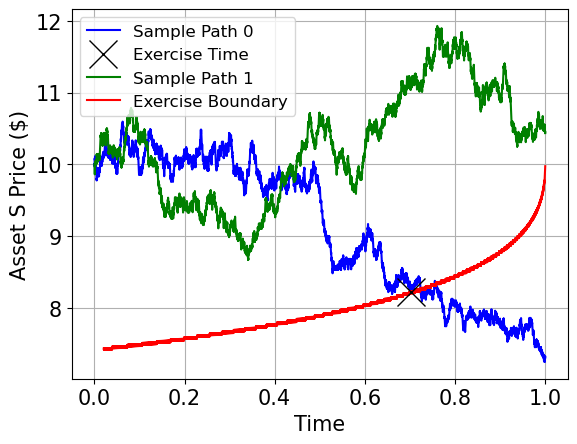

In [14]:
#generate results
put_opt_paths, BA_paths, risky_paths, paths_index, ex_time = generate_paths(n_paths, N, mu, sigma, r, dt, ex_prices)

[0.000e+00 2.000e-04 4.000e-04 ... 9.996e-01 9.998e-01 1.000e+00]


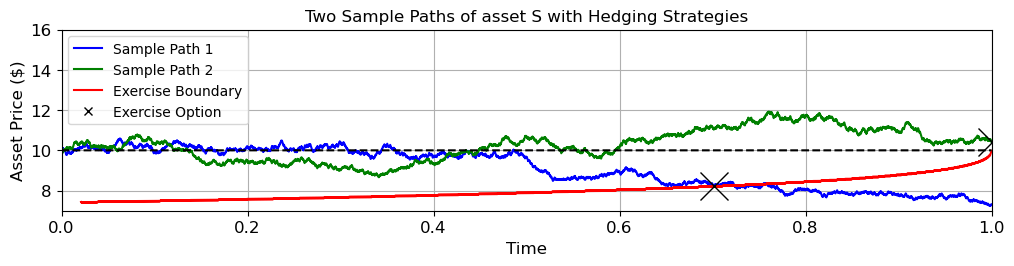

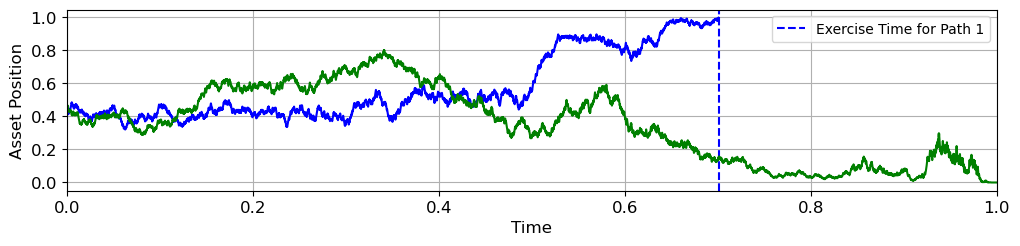

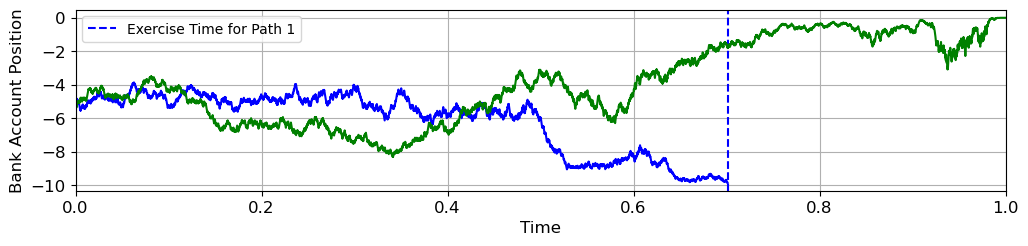

In [15]:
# Now, hedging strategy

# We want a strategy such that the value of the portfolio is equal to zero at time t, and has equal value at time t+1, whether the assets move up or down
# The stratgey is (alpha, beta, 1), where alpha is the position in S, beta is the position in B and 1 is the position in the put option
# Since the option was priced using the FTAP, if the price is the same at t+1 if assets move up or down, and the value at time t = 0, the the portfolio
# value at time t+1 must also be 0 no matter what.

# For the portfolio to have value 0 at time t, beta = -(Opt_value_t + alpha*S_t)/exp(rt)

# Setting the value of the option equal at time t+1 whether we move up or down, we can isolate alpha, and get
# alpha = (Opt_value_down - Opt_value_up)/S_t(exp(r*dt+sigma*sqrt(dt))-exp(r*dt+sigma*sqrtdt)))
def create_hedge_strategy(N, n_paths, put_opt_tree, risky_tree, BA_tree, paths_index, risky_paths, put_opt_paths, BA_paths, ex_time):
    alpha = np.zeros((N, N))
    beta = np.zeros((N, N))
    
    for i in range(N):
        for j in range(0, i+1):
            alpha[j, i] = (put_opt_tree[j+1, i+1] - put_opt_tree[j, i+1])/(risky_tree[j, i]*(np.exp(r*dt+sigma*np.sqrt(dt))-np.exp(r*dt-sigma*np.sqrt(dt))))
            beta[j, i] = -(put_opt_tree[j, i]+alpha[j, i]*risky_tree[j, i])/np.exp(r*dt*i)
    
    # alpha and beta give us the position of S and B at each node that we should take.

    alpha_hedge = np.zeros((n_paths, N))
    beta_hedge =  np.zeros((n_paths, N))
    ex_time[np.isnan(ex_time)] = N



    for path in range(n_paths):
        for t in range(0, int(ex_time[path])):
            alpha_hedge[path, t] = alpha[paths_index[path, t], t]
            beta_hedge[path, t] = beta[paths_index[path, t], t]
    
    
    portfolio_value = np.zeros((n_paths, N))
    
    for path in range(n_paths):
        for t in range(0, int(ex_time[path])):
            portfolio_value[path, t] = alpha_hedge[path, t] * risky_paths[path, t] + beta_hedge[path, t] * BA_paths[path, t] + put_opt_paths[path, t]
    t = np.linspace(0, T, N+1)
    colors = ['b', 'g']

    

    print(t)
    plt.figure(figsize = (12,8))
    plt.subplot(3,1,1)                     
    for i in range(n_paths):
        plt.plot(t, risky_paths[i,:], label="Sample Path " + str(i+1), color = colors[i])
        if not np.isnan(ex_time[i]):
            plt.plot(int(ex_time[i])/N, risky_paths[i, int(ex_time[i])], "kx",  zorder=10, markersize=20)
    plt.plot(t, ex_prices, label = "Exercise Boundary", color = 'r')
    plt.plot(t, [K]*(N+1),  color ='k', linestyle = '--')
    plt.legend(fontsize =12)
    plt.grid()
    plt.xlim(0,1)
    plt.xlabel("Time", fontsize = 12)
    plt.ylabel("Asset Price ($)", fontsize = 12)
    plt.legend( fontsize = 12, loc = "upper left", framealpha=0)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylim(7,16)
    plt.plot(-1,-1, "kx", label = "Exercise Option")
    plt.title("Two Sample Paths of asset S with Hedging Strategies", fontsize =12)
    plt.legend()

    plt.show()
    
    plt.figure(figsize = (12,8))
    plt.subplot(3,1,2)
    for i in range(0,2):
        plt.plot(t[0:int(ex_time[i])], alpha_hedge[i,0:int(ex_time[i])], color = colors[i])
        if ex_time[i] < N:
            plt.axvline(t[int(ex_time[i])], linestyle = "--", label = "Exercise Time for Path " + str(i+1), color= colors[i])
    
    plt.xlabel("Time", fontsize = 12)
    plt.ylabel("Asset Position", fontsize = 12)
    plt.legend( fontsize = 12, loc = "best", framealpha=0)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid()
    plt.legend()
    plt.xlim(0,1)
    plt.show()
    plt.figure(figsize = (12,8))
    plt.subplot(3,1,3)
    colors = ['b', 'g']
    for i in range(0,2):
        plt.plot(t[0:int(ex_time[i])], beta_hedge[i,0:int(ex_time[i])], color = colors[i])
        if ex_time[i] < N:
            plt.axvline(t[int(ex_time[i])], linestyle = "--", label = "Exercise Time for Path " + str(i+1), color= colors[i])
    
    plt.xlabel("Time", fontsize = 12)
    plt.ylabel("Bank Account Position", fontsize = 12)
    plt.legend( fontsize = 12, loc = "best", framealpha=0)
    
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlim(0,1)
    plt.grid()
    plt.legend()
    plt.show()

    return alpha_hedge, beta_hedge, portfolio_value
  
alpha_hedge, beta_hedge, portfolio_value = create_hedge_strategy(N, n_paths, put_opt_tree, risky_tree, BA_tree, paths_index, risky_paths, put_opt_paths, BA_paths, ex_time)

In [ ]:
#Now, put it all together:
sigmas = [0.1, 0.2, 0.3]
rates = [0, 0.02, 0.04]

option_prices = []
exercise_prices = []
option_paths = []
risky_asset_paths = []
bank_paths = []
alpha_positions = []
beta_positions = []
portfolios = []
ex_times = []

for r in rates:
    for sigma in sigmas:
        print(r, sigma)
        risky_tree = generate_risky_tree(N, r, sigma, dt)
        BA_tree = generate_BA_tree(N, r, sigma, dt)
        put_opt_tree, price, ex_prices = generate_option_tree_Bnum(N, dt, K, r, sigma)
        put_opt_paths, BA_paths, risky_paths, paths_index, ex_time = generate_paths(n_paths, N, mu, sigma, r, dt, ex_prices)
        alpha_hedge, beta_hedge, portfolio_value = create_hedge_strategy(N, n_paths, put_opt_tree, risky_tree, BA_tree, paths_index, risky_paths, put_opt_paths, BA_paths, ex_time)
    
        option_prices.append(price)
        print(r)
        print(sigma)
        print(price)
        exercise_prices.append(ex_prices)
        option_paths.append(put_opt_paths)
        risky_asset_paths.append(risky_paths)
        bank_paths.append(BA_paths)
        alpha_positions.append(alpha_hedge)
        beta_positions.append(beta_hedge)
        portfolios.append(portfolio_value)
        ex_times.append(ex_time)



In [ ]:
t= np.linspace(0,T,N+1)
figure, axis = plt.subplots(3, 3,figsize=(15, 15)) 
for ax in axis.flatten():
    ax.grid()
# For Decision Boundaries 
for i in range(9):
    axis[i // 3, i % 3].plot(t, [K]*(N+1), label="Strike Price")
    axis[i // 3, i % 3].plot(t, exercise_prices[i], label="Exercise Boundary") 
    axis[i // 3, i % 3].set_title("Volatility: "+str(sigmas[i % 3]) + ", Rate: " + str(rates[i // 3])) #+ " Option Value: " + str(option_prices[i]))

custom_ylim = (6, 11)
figure.supylabel('Underlying Price')
figure.supxlabel('t')


# Setting the values for all axes.
plt.setp(axis, ylim=custom_ylim)
  
# Combine all the operations and display 
plt.legend()
figure.show() 

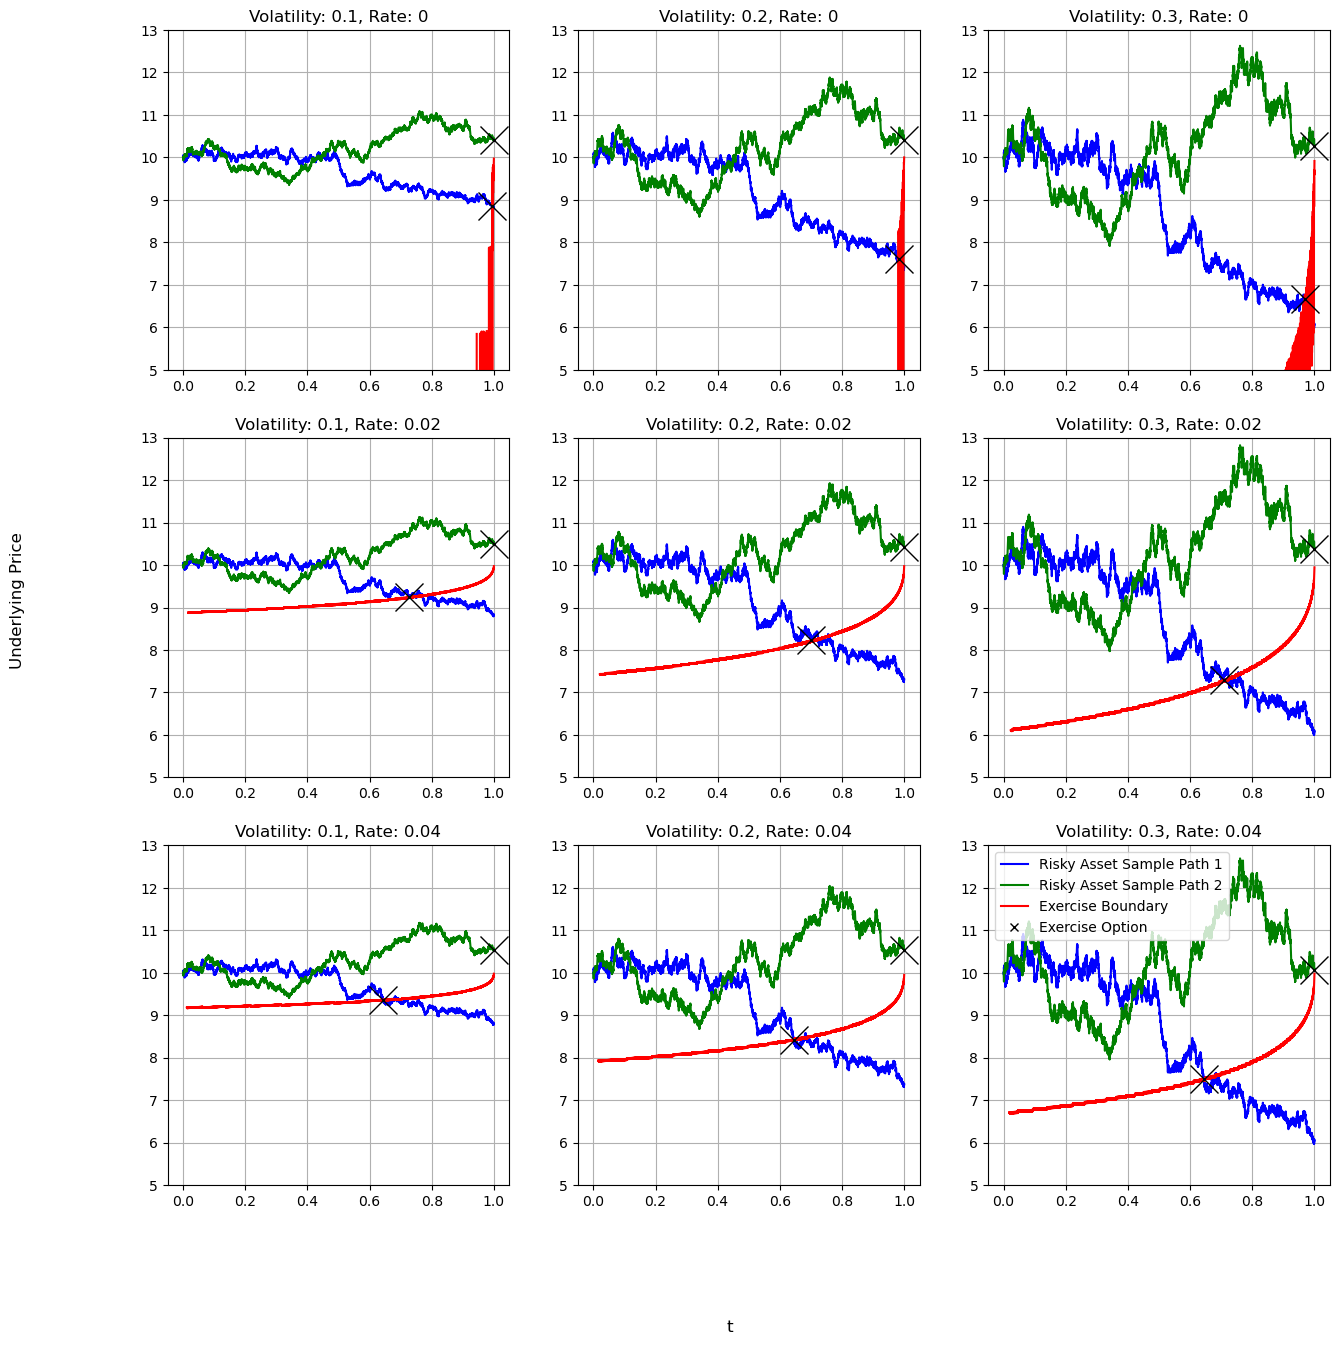

In [130]:
# For Sample Paths
colors = ['b', 'g']
figure, axis = plt.subplots(3, 3,figsize=(15, 15)) 
for ax in axis.flatten():
    ax.grid()
for i in range(9):
    for j in range(n_paths):
        axis[i // 3, i % 3].plot(t, risky_asset_paths[i][j, :], label="Risky Asset Sample Path " + str(j+1), color = colors[j])
        if not np.isnan(ex_times[i][j]):
            axis[i // 3, i % 3].plot(int(ex_times[i][j])/N, risky_asset_paths[i][j, int(ex_times[i][j])], "kx", zorder=10, markersize=20)
    axis[i // 3, i % 3].plot(t, exercise_prices[i], label="Exercise Boundary", color = 'r') 
    axis[i // 3, i % 3].set_title("Volatility: "+str(sigmas[i % 3]) + ", Rate: " + str(rates[i // 3])) #+ " Option Value: " + str(option_prices[i]))

custom_ylim = (5, 13)
custom_xlim = (-0.05, 1.05)
figure.supylabel('Underlying Price')
figure.supxlabel('t')

plt.plot(-1,-1, "kx", label = "Exercise Option") # Hacky way of adding legend for exercise time


# Setting the values for all axes.
plt.setp(axis,xlim=custom_xlim, ylim=custom_ylim)
  
# Combine all the operations and display 
plt.legend()
plt.show() 

In [ ]:
# For Portfolio Values
figure, axis = plt.subplots(3, 3,figsize=(15, 15))
t=np.linspace(0,T, N)
for i in range(9):
    for j in range(n_paths):
        axis[i // 3, i % 3].plot(t, portfolios[i][j, :], label="Portfolio Value " + str(j+1)) 
    axis[i // 3, i % 3].set_title("Volatility: "+str(sigmas[i % 3]) + ", Rate: " + str(rates[i // 3])) #+ " Option Value: " + str(option_prices[i]))

custom_ylim = (-1, 1)
figure.supylabel('Portfolio Value')
figure.supxlabel('t')


# Setting the values for all axes.
plt.setp(axis, ylim=custom_ylim)
  
# Combine all the operations and display 
plt.legend()
plt.show() 

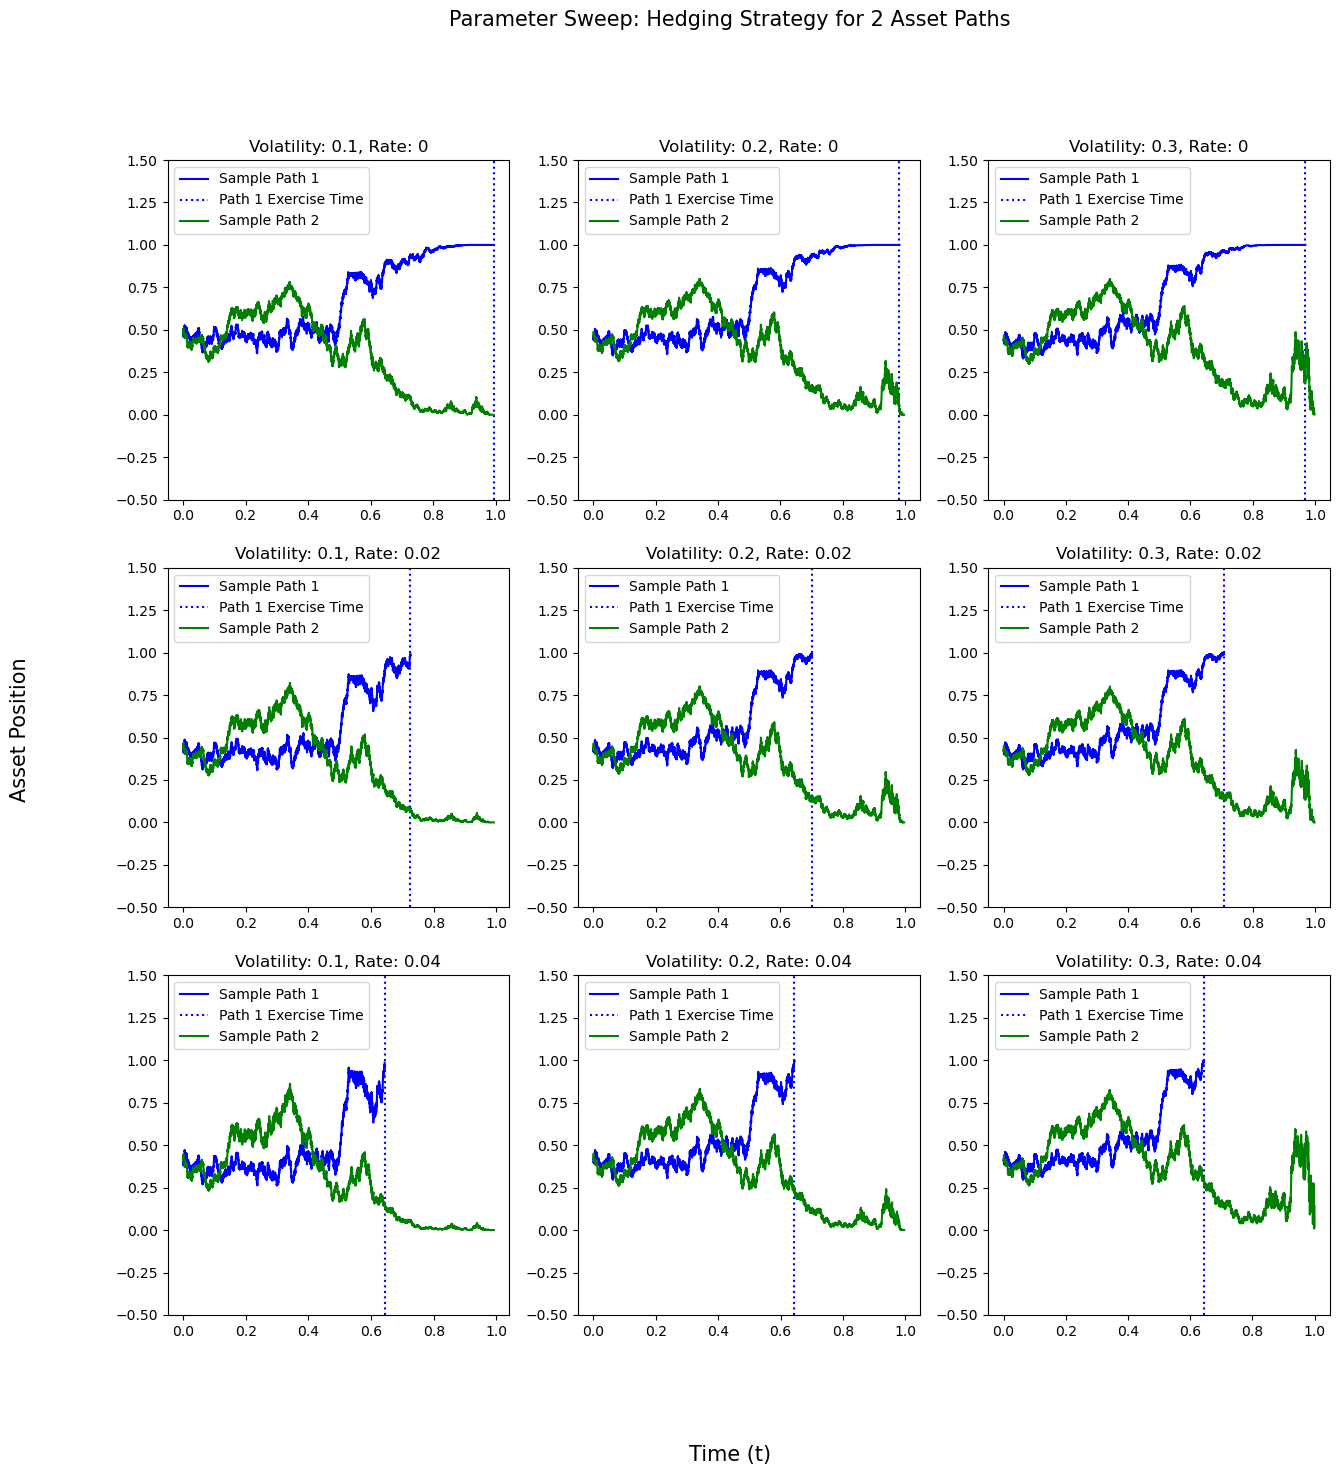

In [133]:
# Show Hedging Strategies
figure, axis = plt.subplots(3, 3,figsize=(15, 15))
colors = ['b', 'g']
t=np.linspace(0,T, N)
for i in range(9):
    alpha_positions[i][alpha_positions[i] == 0] = np.nan
    for j in range(n_paths):
        axis[i // 3, i % 3].plot(t, alpha_positions[i][j, :], label="Sample Path " + str(j+1), color = colors[j])
        if ex_times[i][j] < N:
            axis[i // 3, i % 3].axvline(ex_times[i][j]/N, ls=":", label = "Path " + str(j+1) + " Exercise Time", color =colors[j])
    axis[i // 3, i % 3].set_title("Volatility: "+str(sigmas[i % 3]) + ", Rate: " + str(rates[i // 3])) #+ " Option Value: " + str(option_prices[i]))
    axis[i // 3, i % 3].legend()

custom_ylim = (-0.5, 1.5)

figure.supylabel('Asset Position', fontsize = 15)
figure.supxlabel('Time (t)', fontsize = 15)
figure.suptitle("Parameter Sweep: Hedging Strategy for 2 Asset Paths", fontsize = 15)

# Setting the values for all axes.
plt.setp(axis, ylim=custom_ylim)
  
# Combine all the operations and display 
plt.show() 

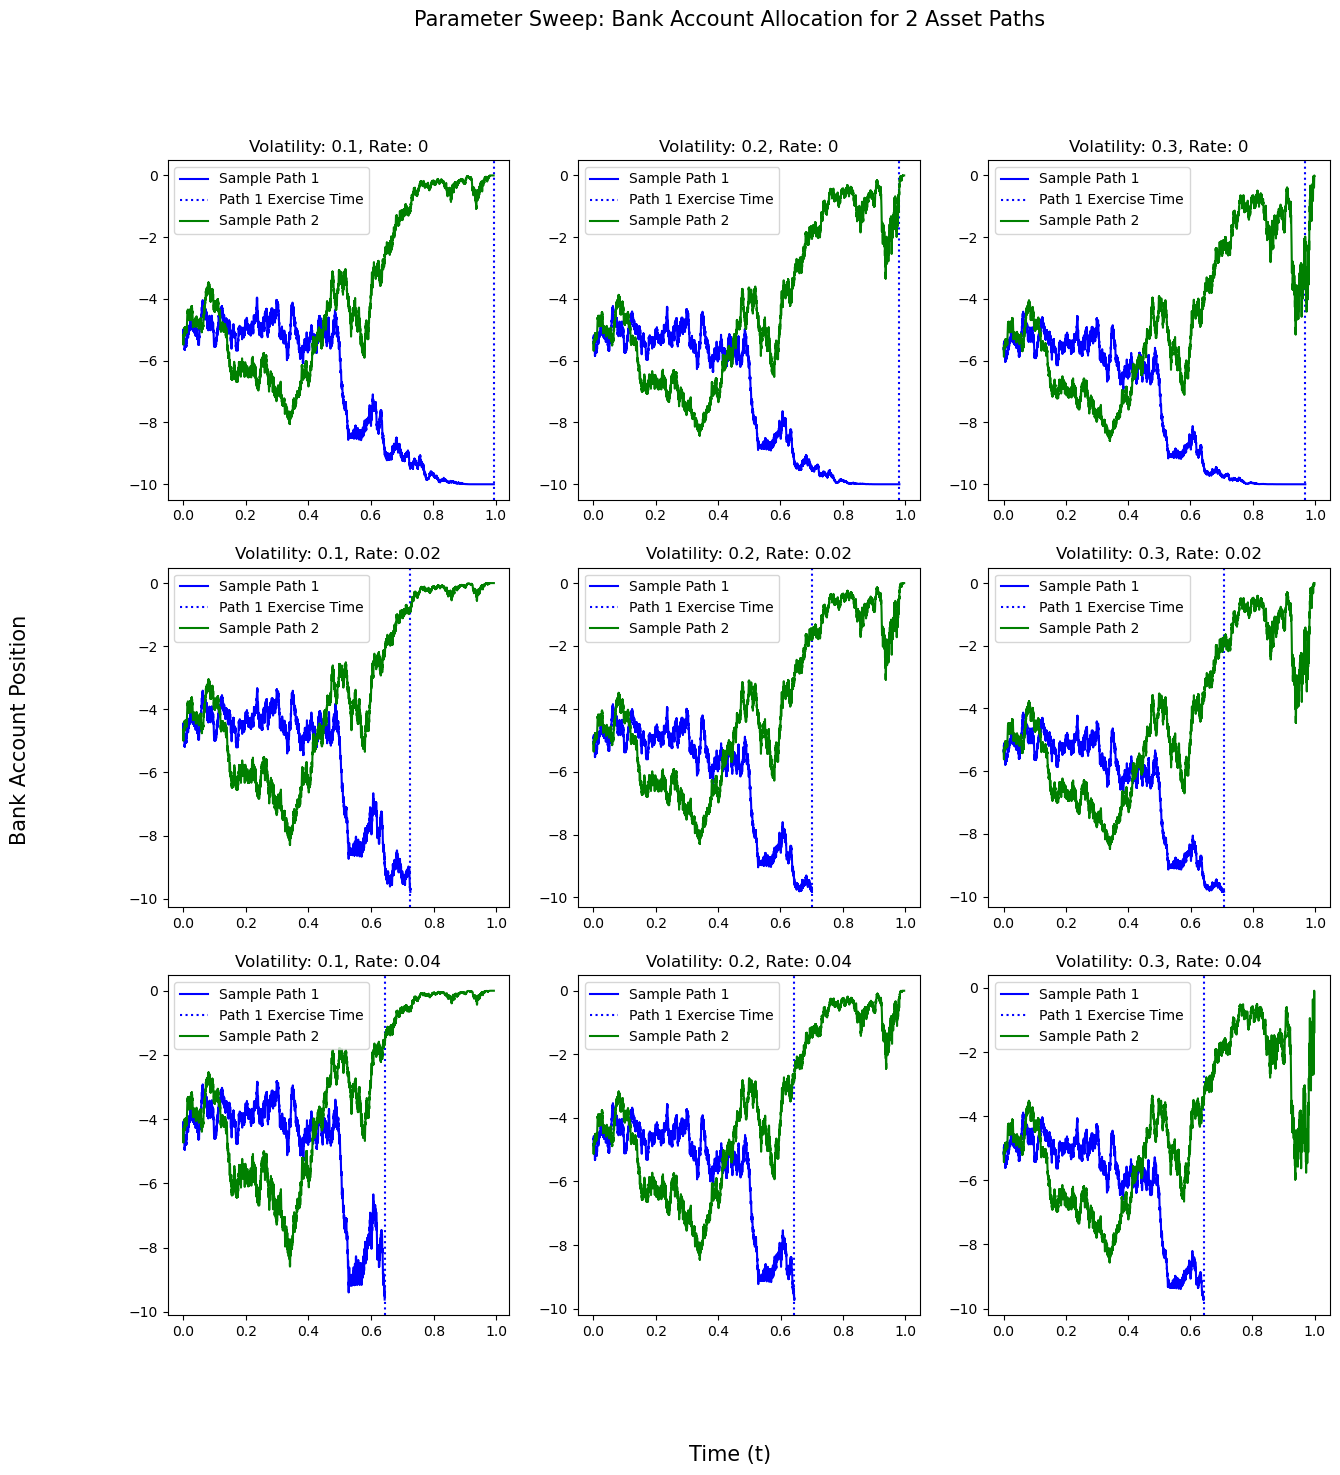

In [132]:
# Show Hedging Strategies
figure, axis = plt.subplots(3, 3,figsize=(15, 15))
t=np.linspace(0,T, N)
for i in range(9):
    beta_positions[i][beta_positions[i] == 0] = np.nan
    for j in range(n_paths):
        axis[i // 3, i % 3].plot(t, beta_positions[i][j, :], label="Sample Path " + str(j+1), color = colors[j])
        if ex_times[i][j] < N:
            axis[i // 3, i % 3].axvline(ex_times[i][j]/N, ls=":", label = "Path " + str(j+1) + " Exercise Time", color = colors[j])
    axis[i // 3, i % 3].set_title("Volatility: "+str(sigmas[i % 3]) + ", Rate: " + str(rates[i // 3])) #+ " Option Value: " + str(option_prices[i]))
    axis[i // 3, i % 3].legend()

#custom_ylim = (-0.5, 1.5)
figure.supylabel('Bank Account Position', fontsize = 15)
figure.supxlabel('Time (t)', fontsize = 15)
figure.suptitle("Parameter Sweep: Bank Account Allocation for 2 Asset Paths", fontsize = 15)


# Setting the values for all axes.
#plt.setp(axis, ylim=custom_ylim)
  
# Combine all the operations and display 
plt.show()

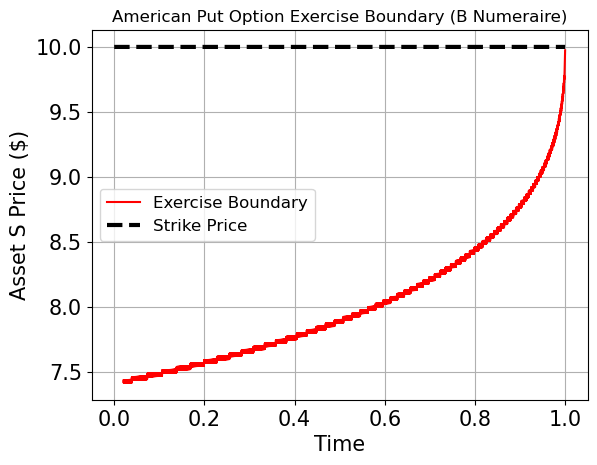

In [20]:
# 2b

N = 5000           # Simualtion steps 
T = 1               # Time to maturity
n_paths = 10000          # Number of simulation paths
S0 = 10             # Initial stock price
r = 0.02            # Risk-free interest rate
sigma = 0.2         # Volatility
seed = 5000         # Set seed
K = 10             # Strike price
mu = 0.05
dt = T/N
B0 =1

risky_tree = generate_risky_tree(N, r, sigma, dt)
BA_tree = generate_BA_tree(N, r, sigma, dt)
put_opt_tree, price, ex_prices = generate_option_tree_Bnum(N, dt, K, r, sigma)

opt_paths_2b, BA_paths_2b, risky_paths_2b, paths_index_2b, ex_time_2b = generate_paths(n_paths, N, mu, sigma, r, dt, ex_prices)

def profit_and_stopping_time(K, r, T, N, price, ex_prices, risky_paths):
    
    stopping_time = [float('inf') for _ in range(n_paths)]
    profit = [-price for _ in range(n_paths)]
    
    for j in range(n_paths):
        for i in range(N + 1):
            if risky_paths[j][i] < ex_prices[i]:
                stopping_time[j] = i
                intrinsic_value = max(K - risky_paths[j][i], 0)
                profit[j] = intrinsic_value * np.exp(-r * i * T / N) - price
                break

    return stopping_time, profit

Probability of Exercise: 0.4481
Mean Profit Conditioned on Exercise: 0.6626924478069847


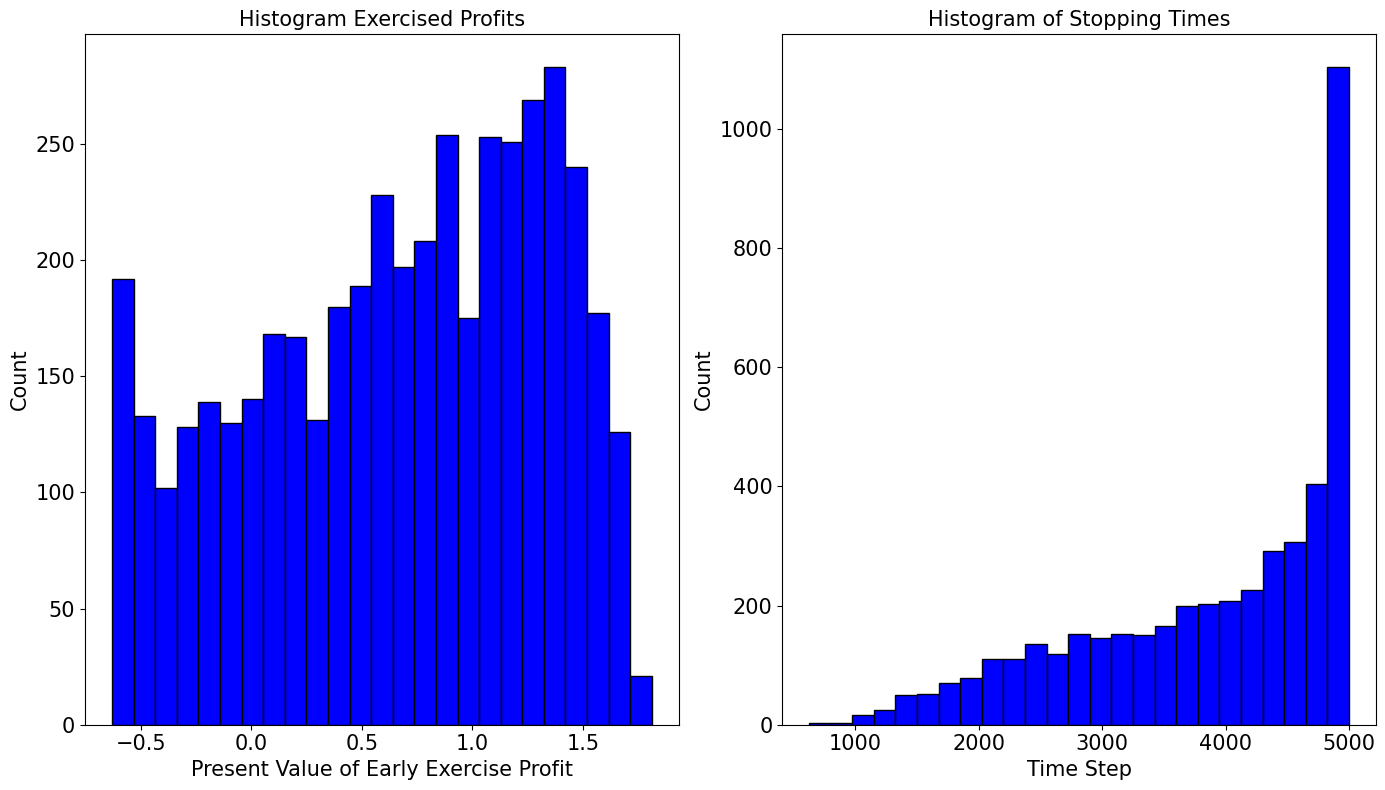

In [21]:
np.random.seed(2900)

stop, profit = profit_and_stopping_time(K, r, T, N, price, ex_prices, risky_paths_2b)

# Filter only the P&L of exercised options (stopping time is not infinite)
exercised_profits = [p for i, p in zip(stop, profit) if i != float('inf')]
exercised_paths = [value for value in stop if value != float('inf')]
p_exercise = len(exercised_profits) / len(profit)

print("Probability of Exercise:", p_exercise)
print("Mean Profit Conditioned on Exercise:", st.mean(exercised_profits))


# Create two separate subplots
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)  # Subplot 1 for Profit
plt.hist(exercised_profits, bins = 25, color = 'b' , edgecolor = 'k')
plt.title("Histogram Exercised Profits", fontsize =15)
plt.xlabel("Present Value of Early Exercise Profit", fontsize =15)
plt.ylabel("Count", fontsize =15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize =15)
plt.subplot(1, 2, 2)  # Subplot 2 for Stopping Times
plt.hist(exercised_paths, bins = 25, color = 'b' , edgecolor = 'k')
plt.title("Histogram of Stopping Times", fontsize =15)
plt.xlabel("Time Step", fontsize =15)
plt.ylabel("Count", fontsize =15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize =15)
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


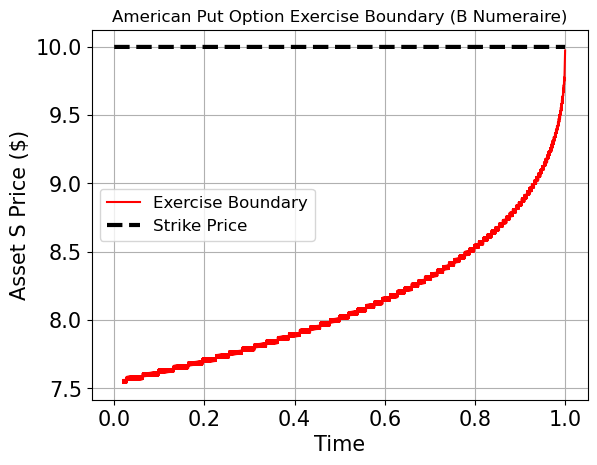

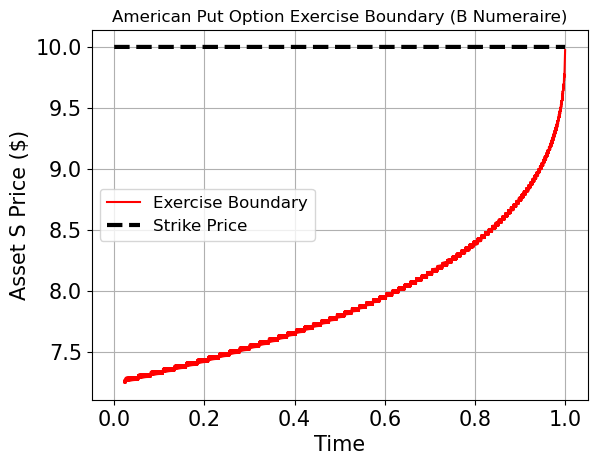

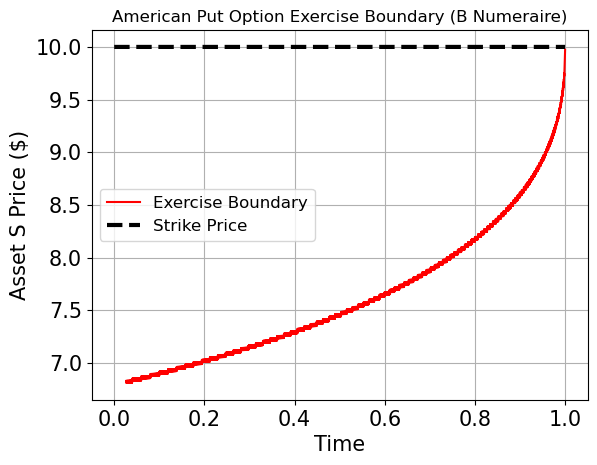

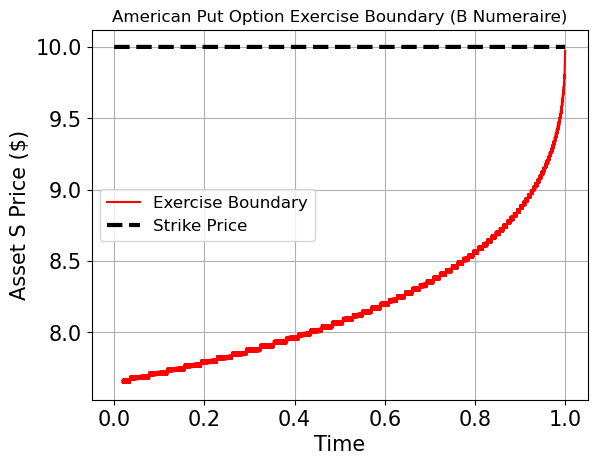

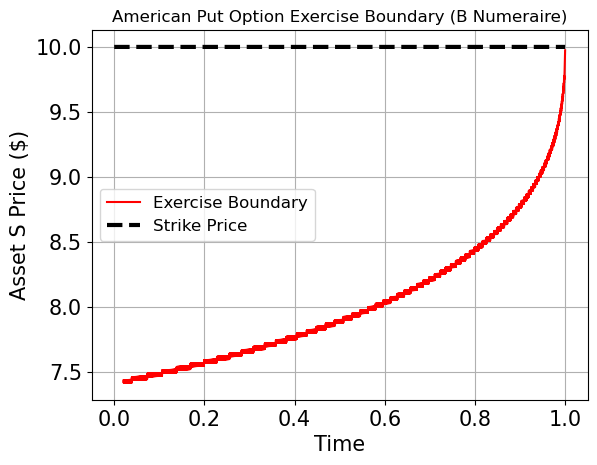

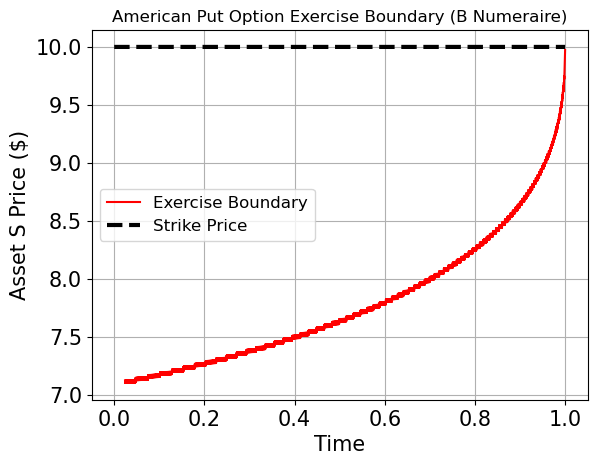

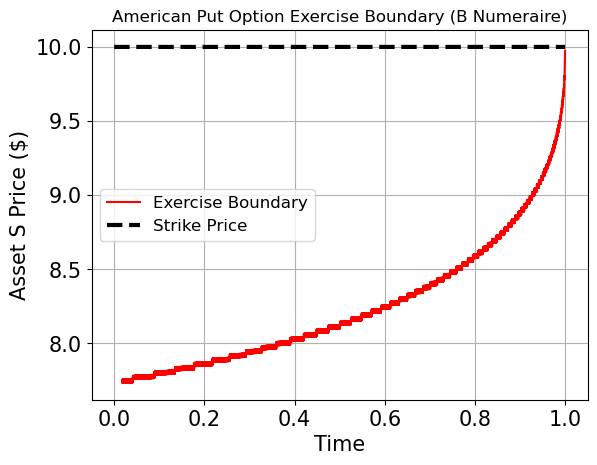

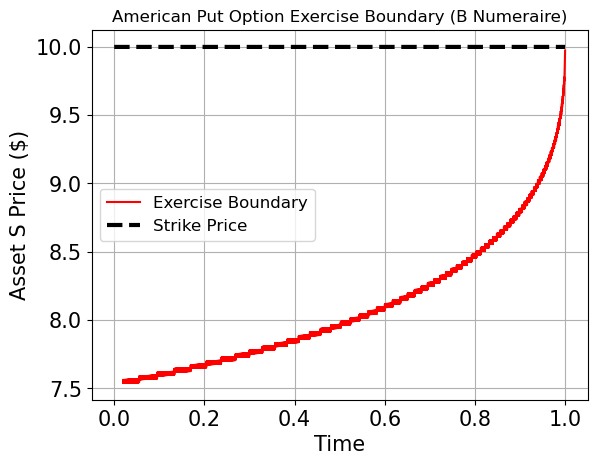

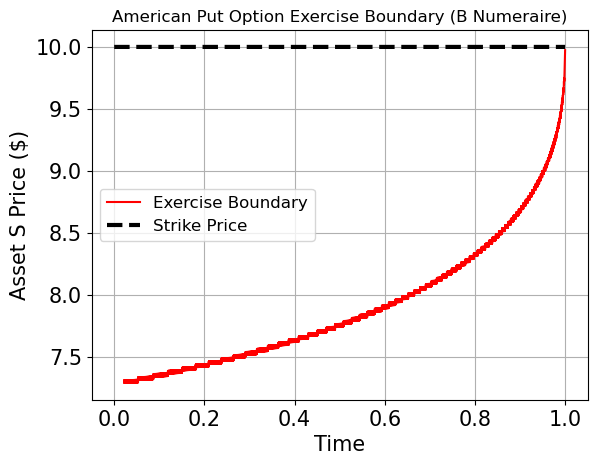

In [25]:
#2bii

sigmas = [0.1, 0.2, 0.3]
rates = [0, 0.02, 0.04]

option_prices_ii = []
exercise_prices_ii = []
option_paths_ii = []
risky_asset_paths_ii = []
bank_paths_ii = []
ex_times_ii = []
ex_profits_ii = []
exercise_probs_ii = []
mean_profit_ii = []
ex_paths_ii = []


for r in rates:
    for sigma in sigmas:
        risky_tree_ii = generate_risky_tree(N, r, sigma, dt)
        BA_tree_ii = generate_BA_tree(N, r, sigma, dt)
        put_opt_tree_ii, price_ii, ex_prices_ii = generate_option_tree_Bnum(N, dt, K, r, sigma)
        opt_paths_ii, BA_paths_ii, risky_paths_ii, paths_index_ii, ex_time_ii = generate_paths(n_paths, N, mu, sigma, r, dt, ex_prices_ii)
        
        option_prices_ii.append(price_ii)
        exercise_prices_ii.append(ex_prices_ii)
        option_paths_ii.append(put_opt_tree_ii)
        risky_asset_paths_ii.append(risky_paths_ii)
        bank_paths_ii.append(BA_paths_ii)
        ex_times_ii.append(ex_time_ii)
        
        np.random.seed(2900)
        stop_ii, profit_ii = profit_and_stopping_time(K, r, T, N, price_ii, ex_prices_ii, risky_paths_ii)
        
        exercised_profits_ii = [p for i, p in zip(stop_ii, profit_ii) if i != float('inf')]
        exercised_paths_ii = [value for value in stop_ii if value != float('inf')]
        
        ex_profits_ii.append(exercised_profits_ii)
        ex_paths_ii.append(exercised_paths_ii)
        mean_profit_ii.append(st.mean(exercised_profits_ii))
        exercise_probs_ii.append(len(exercised_profits_ii) / len(profit_ii))

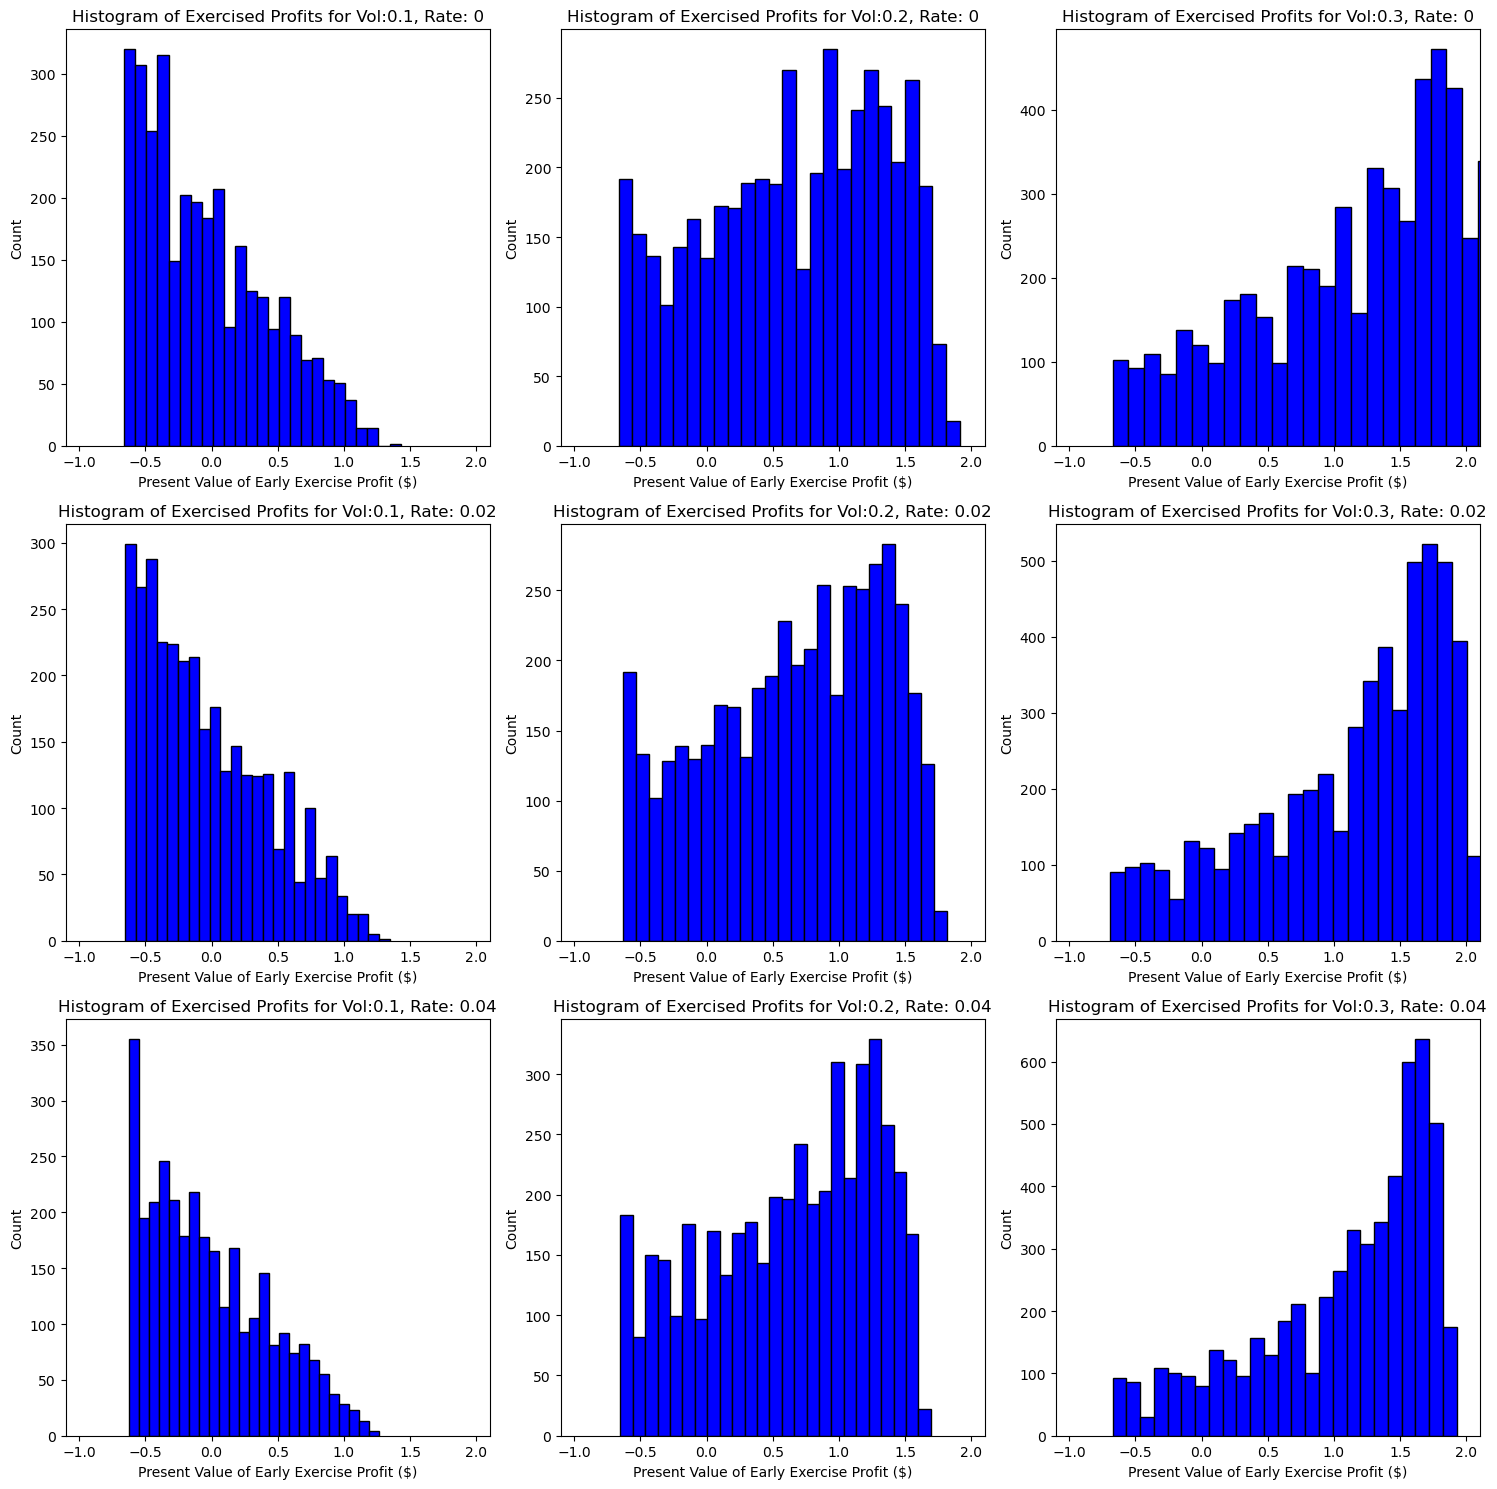

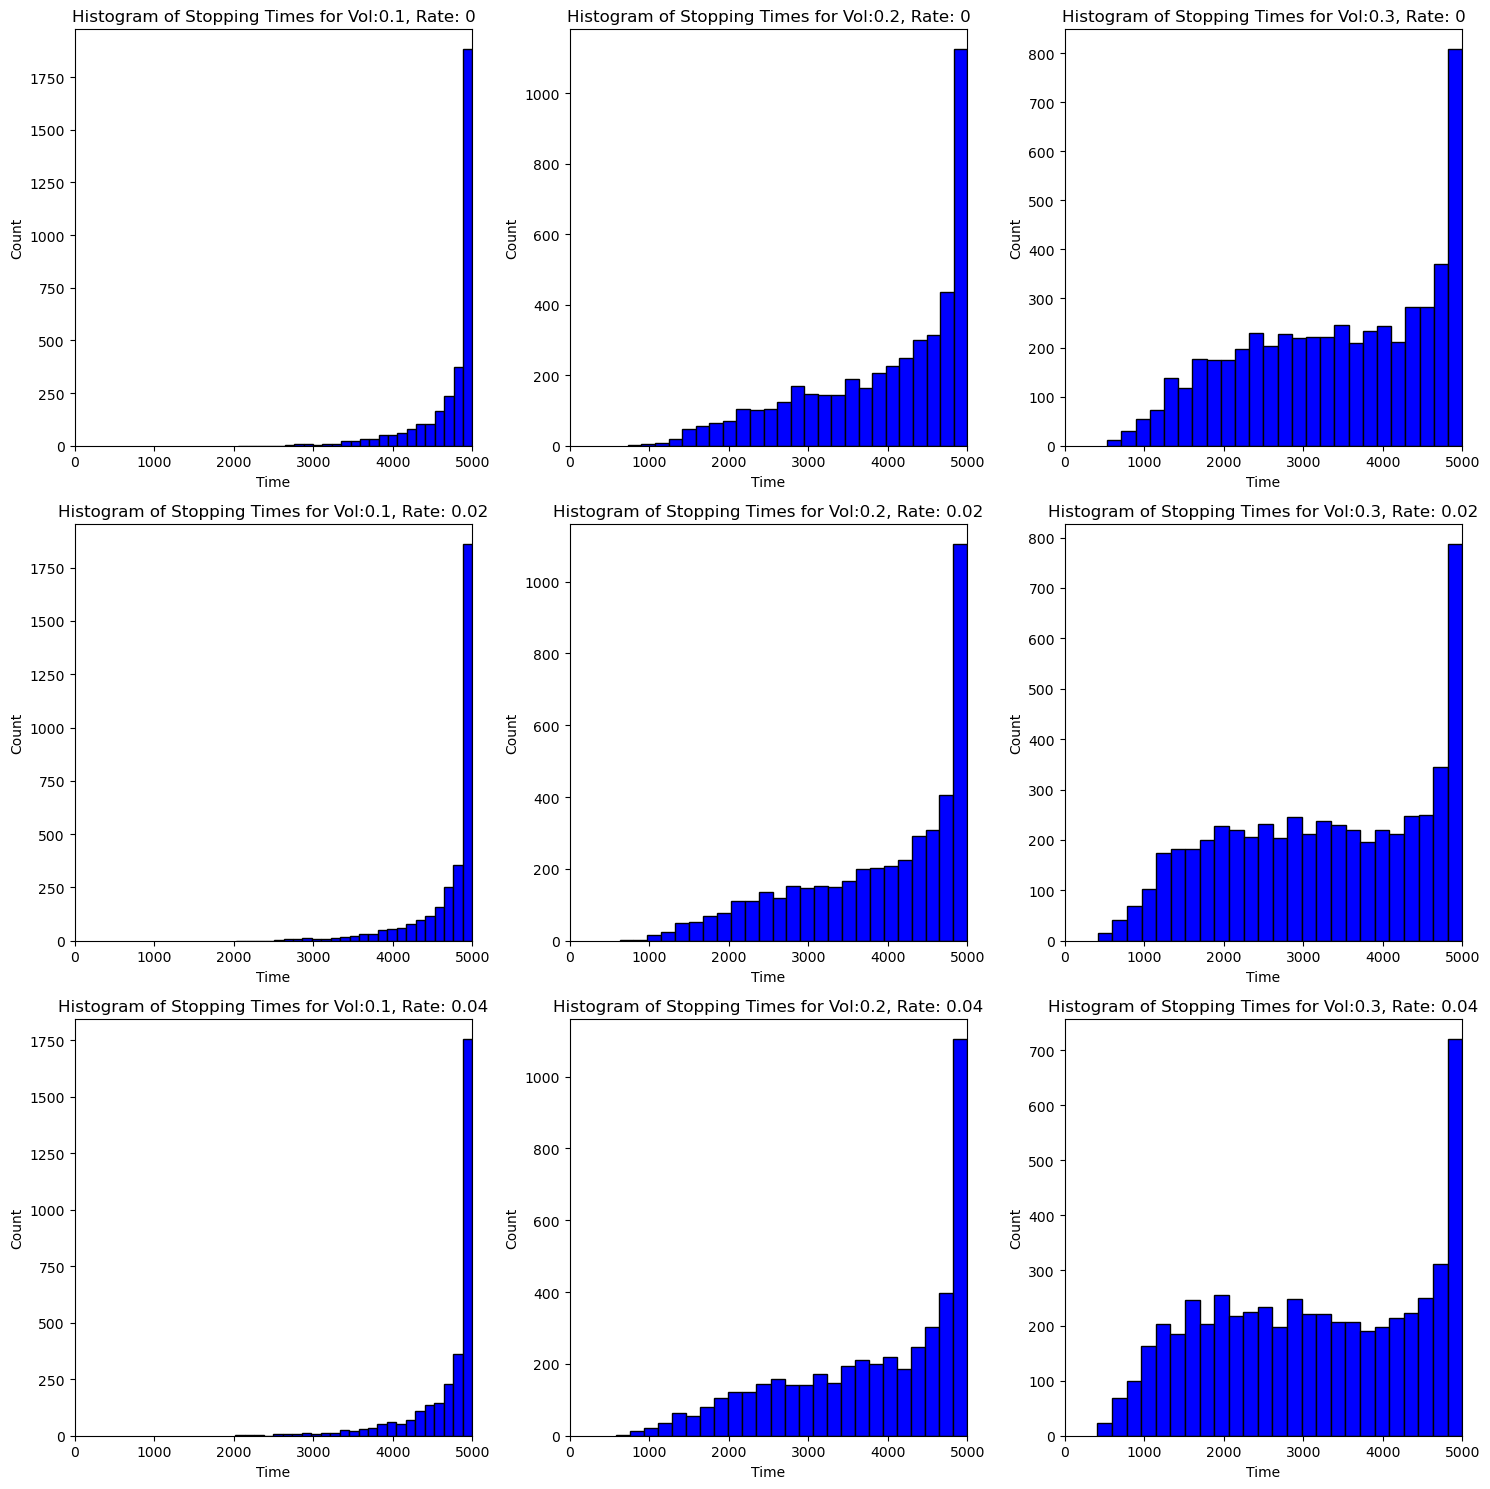

In [27]:
# Create two separate subplots

plt.figure(figsize=(15, 15))

for i in range(9):
    plt.subplot(3, 3, i+1)  
    plt.hist(ex_profits_ii[i], edgecolor = 'k', bins =25, color="blue")
    plt.title("Histogram of Exercised Profits for Vol:" + str(sigmas[i % 3]) + ", Rate: " + str(rates[i // 3]))
    plt.xlabel("Present Value of Early Exercise Profit ($)")

    plt.xlim(-1.1,2.1)
    plt.ylabel("Count")

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()
    
plt.figure(figsize=(15, 15))

for i in range(9):
    plt.subplot(3, 3, i+1)  
    plt.hist(ex_paths_ii[i], edgecolor = 'k', bins =25, color="blue")
    plt.title("Histogram of Stopping Times for Vol:" + str(sigmas[i % 3]) + ", Rate: " + str(rates[i // 3]))
    plt.xlabel("Time")
    plt.xlim(0,5000)
    plt.ylabel("Count")

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


In [28]:
#2biii

risky_asset_paths_iii = []
bank_paths_iii = []
ex_times_iii = []
ex_profits_iii = []
exercise_probs_iii = []
mean_profit_iii = []
ex_paths_iii = []

sigmas_iii = [0.1, 0.15, 0.25, 0.3]
r = 0.02
opt_price = option_prices_ii[4] #Option is purchased with sigma = 0.2
ex_bound = exercise_prices_ii[4] #Use exercise boundary for sigma = 0.2

for sigma in sigmas_iii:
    
    opt_paths_iii, BA_paths_iii, risky_paths_iii, paths_index_iii, ex_time_iii = generate_paths(n_paths, N, mu, sigma, r, dt, ex_bound)
        
    risky_asset_paths_iii.append(risky_paths_iii)
    bank_paths_iii.append(BA_paths_iii)
    ex_times_iii.append(ex_time_iii)
        
    np.random.seed(2900)
    stop_iii, profit_iii = profit_and_stopping_time(K, r, T, N, opt_price, ex_bound, risky_paths_iii)
    exercised_profits_iii = [p for i, p in zip(stop_iii, profit_iii) if i != float('inf')]
    exercised_paths_iii = [value for value in stop_iii if value != float('inf')]
        
    ex_profits_iii.append(exercised_profits_iii)
    ex_paths_iii.append(exercised_paths_iii)
    mean_profit_iii.append(st.mean(exercised_profits_iii))
    exercise_probs_iii.append(len(exercised_profits_iii) / len(profit_iii))
        

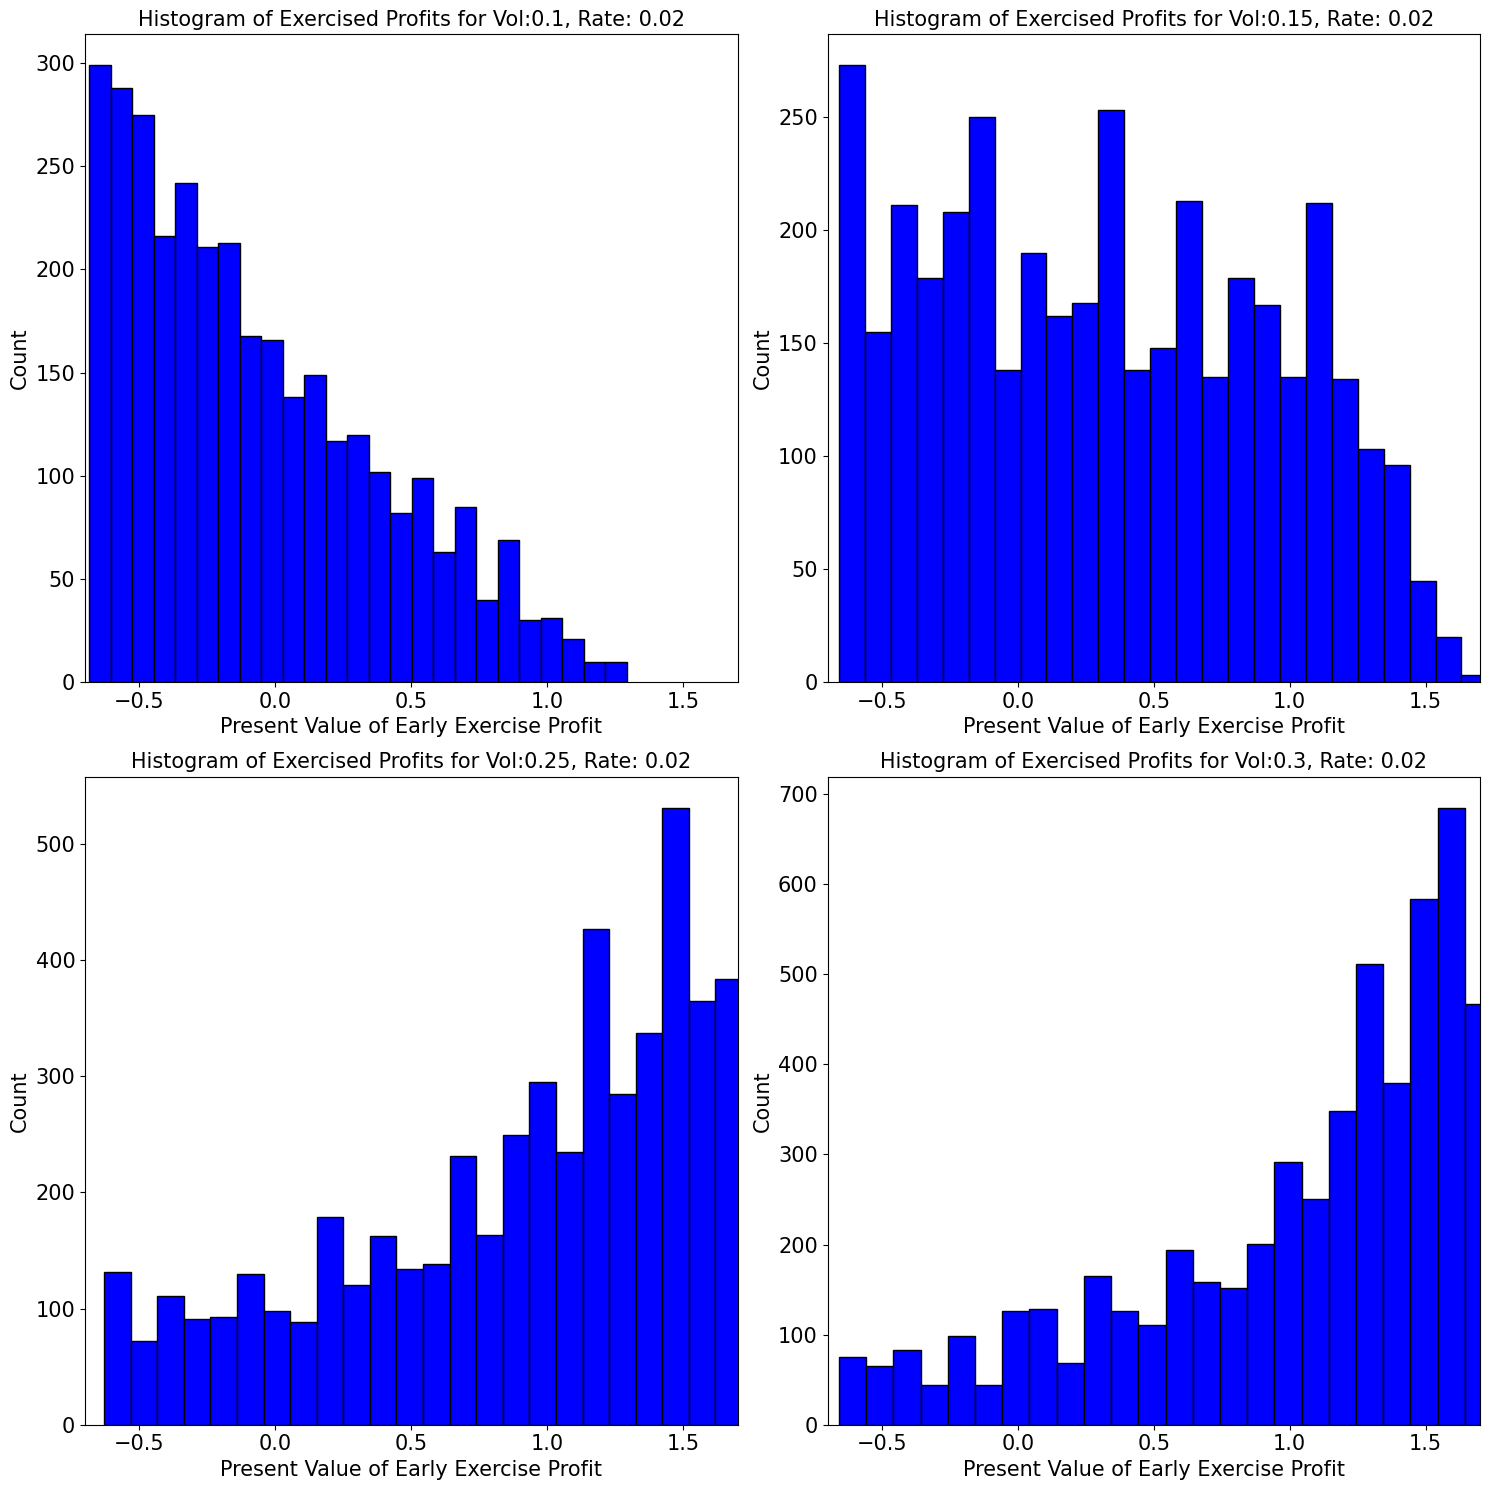

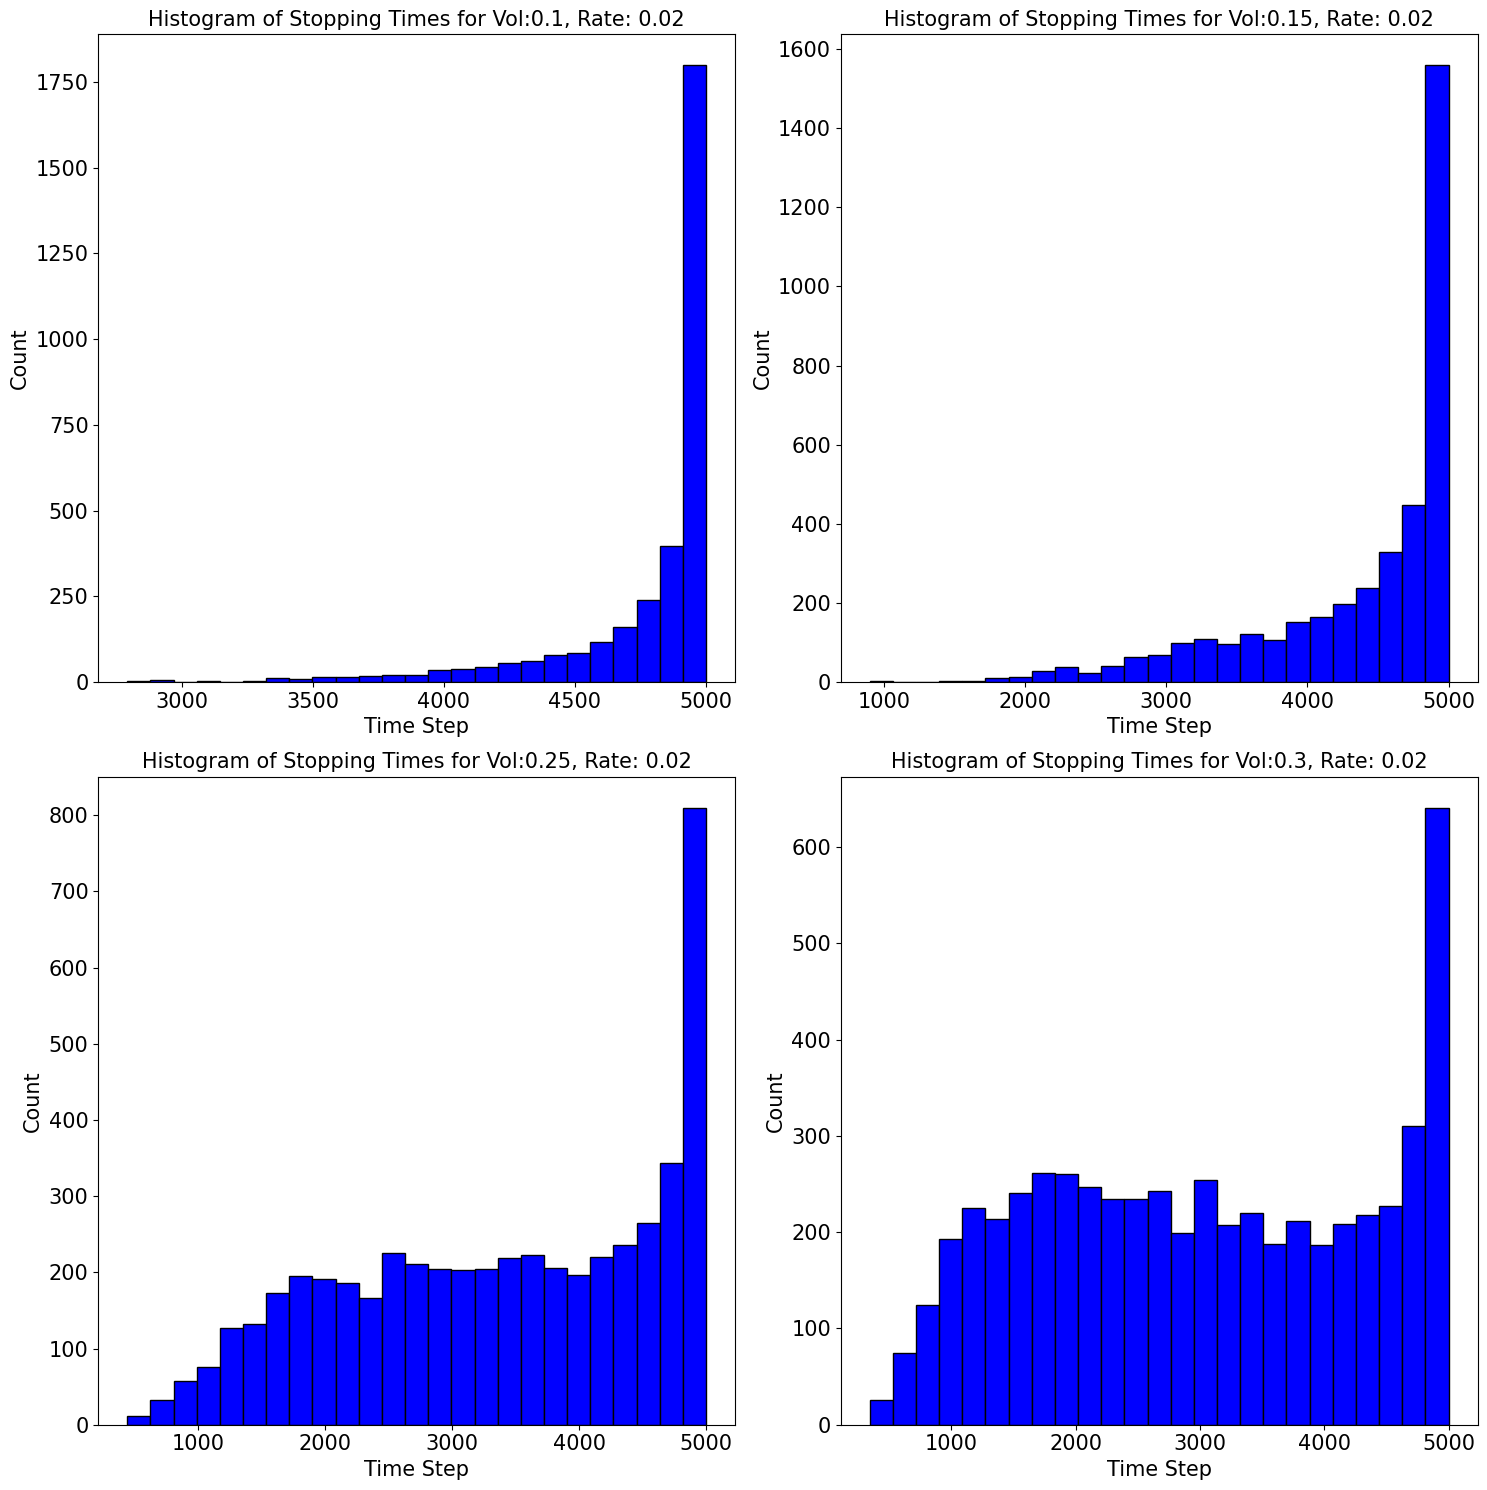

In [33]:
# Create two separate subplots

plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i+1)  
    plt.hist(ex_profits_iii[i], edgecolor = 'k', bins =25, color="blue")
    plt.title("Histogram of Exercised Profits for Vol:" + str(sigmas_iii[i]) + ", Rate: 0.02", fontsize =15)
    plt.xlabel("Present Value of Early Exercise Profit", fontsize =15)
    plt.ylabel("Count", fontsize =15)
    plt.xticks(fontsize =15)
    plt.yticks(fontsize =15)
    plt.xlim(-0.7,1.7)


plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()
    
plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i+1)  
    plt.hist(ex_paths_iii[i], edgecolor = 'k', bins =25, color="blue")
    plt.title("Histogram of Stopping Times for Vol:" + str(sigmas_iii[i]) + ", Rate: 0.02",fontsize =15)
    plt.yticks(fontsize =15)
    plt.xlabel("Time Step", fontsize =15)
    plt.ylabel("Count", fontsize =15)
    plt.xticks(fontsize =15)
    plt.yticks(fontsize =15)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()